In [0]:
while True:
    i = 0 
    i+=1
    i-=1

In [0]:
import json
from pyspark.ml.classification import LogisticRegressionModel
from pyspark.ml import PipelineModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator
from pyspark.sql.functions import when, concat_ws, transform,expr, lit, array, array_distinct, flatten,collect_set
from pyspark.sql.types import *
from pyspark.sql import SparkSession, functions as F
import pandas as pd
import sparknlp
from sparknlp.base import DocumentAssembler
from pyspark.sql.functions import udf, col, size, split
from pyspark.sql.types import ArrayType, StringType, FloatType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, VectorUDT
from sparknlp.annotator import SentenceDetector, BertSentenceEmbeddings
from sparknlp import Finisher
import numpy as np
import json
from pyspark.ml.feature import SQLTransformer
import logging
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.mllib.evaluation import MulticlassMetrics
import re
from pyspark.ml.classification import LogisticRegression, MultilayerPerceptronClassifier, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import IndexToString
from sklearn.metrics import precision_recall_fscore_support
from pyspark.ml.feature import Imputer
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.ml.tuning import ParamGridBuilder


pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

spark = sparknlp.start()

In [0]:
# Read the profiles dataset
profiles = spark.read.parquet('/linkedin/people')
profiles = profiles.withColumnRenamed("сourses", "courses")




In [0]:
# Define a UDF that extracts the first embedding vector from the annotations and converts it to a DenseVector
def extract_embedding_vector(annotations):
    # Check if annotations are not empty and contain the 'embeddings' key
    if annotations and len(annotations) > 0:
        for annotation in annotations:
            # Check if 'token' in metadata is '#' and return a zero vector if true
            if annotation['metadata'].get('token') == '#':
                return Vectors.dense([0] * 128)  # Adjust 128 to your embedding size
            # If 'token' is not '#' and embeddings are present, return the embeddings as a DenseVector
            if 'embeddings' in annotation:
                embedding = annotation['embeddings']
                return Vectors.dense(embedding)
    # Return a zero vector if no suitable embeddings are found or annotations are empty
    return Vectors.dense([0] * 128)  # Adjust 128 to your embedding size

single_embedding_to_dense_vector_udf = udf(extract_embedding_vector, VectorUDT())

def average_arrays(arrays):
    # Convert list of arrays to a 2D numpy array
    np_arrays = np.array(arrays)
    # Compute the mean along the 0th axis (column-wise mean)
    mean_array = np.mean(np_arrays, axis=0)
    # Create a Spark dense vector
    dense_vector = Vectors.dense(mean_array)
    return dense_vector

average_arrays_udf = udf(average_arrays, VectorUDT())
# Define a UDF to extract the first number from the company_size string
def extract_first_number(size_str):
    if size_str is None:
        return None
    # Find the first number in the string
    match = re.search(r'\d+', size_str.replace(',', ''))
    # If a number is found, return it as an integer, otherwise return None
    return int(match.group()) if match else None

# Register the UDF with Spark
extract_first_number_udf = udf(extract_first_number, IntegerType())

In [0]:

# Function to preprocess DataFrame
def initial_preprocess(df):
    original_row_count = df.count()  # Get the original row count
    # df = df.filter(size(df['experience']) <=4)
    # Drop specific columns
    columns_to_drop = ["avatar", "city", "country_code", "education_details",
                       "groups", "name", "people_also_viewed", 
                       "recommendations", "timestamp", "url","current_company:company_id", "current_company","languages"] 
    df = df.drop(*columns_to_drop)
    
    # Transform 'courses' column - > turn all courses to one string
    df = df.withColumn('courses', 
                when((col('courses').isNull()) | (size(col('courses')) == 0), "None")
                    .otherwise(concat_ws(" | ", transform(col("courses"), lambda x: x.title)))
    )

    # Transform 'certifications' column - > turn all certifications to one string
    df = df.withColumn("certifications", 
                when((col("certifications").isNull()) | (size(col("certifications")) == 0), "None")
                    .otherwise(concat_ws(" | ", transform(col("certifications"), lambda x: x.title)))
    )

    # Transform 'education' column, example:
    # [{... "degree": "Bachelor's",... "field": "Computer Science",... "title": "BSc"}]  -> ["Bachelor's in Computer Science at BSc"]
    # if any elements are null then replace with 'unkown'
    df = df.withColumn("education", 
        expr("transform(education, e -> ifnull(e.degree, 'unknown') || ' in ' || ifnull(e.field, 'unknown') || ' at ' || ifnull(e.title, 'unknown'))")
        )
    
    # turn the list into seperate columns -> education_1,...,education_4
    education_cols = []
    max_length=4
    # Generate the new columns
    for i in range(max_length):
        # For each position in the list, create a new column
        # If the index is out of bounds for the list, fill with "None"
        education_cols.append(
            when(col("education").getItem(i).isNotNull(), col("education").getItem(i))
            .otherwise(lit("None")).alias(f'education_{i+1}')
        )

    # Select the original DataFrame columns and the new columns
    df = df.select('*', *education_cols)\
                    .drop("education")

    # create companies column -> new col is a list of companies
    df = df.withColumn(
        "list_of_companies",
        F.when(
            (F.col("experience").isNull()) | (F.size(F.col("experience")) == 0),
            "None"
        ).otherwise(
            F.expr("""
                CASE 
                    WHEN size(array_remove(transform(experience, x -> IF(x.company IS NULL OR x.company = '', 'None', x.company)), 'None')) = 0 THEN 'None'
                    ELSE concat_ws(' | ', array_remove(transform(experience, x -> IF(x.company IS NULL OR x.company = '', 'None', x.company)), 'None'))
                END
            """)
        )
    )
    
    # Define the transformation logic:
    # 1. For each item in the experience list, prefer 'description' over 'title', skip if both are null.
    # 2. Concatenate the resulting strings into one, separated by spaces.
    df = df.withColumn(
        "experience",
        concat_ws(" | ", 
            expr("""
                TRANSFORM(
                    experience, 
                    x -> CASE 
                            WHEN x.description IS NOT NULL THEN x.description 
                            WHEN x.title IS NOT NULL THEN x.title 
                            ELSE NULL 
                        END
                )
            """)
        )
    )
    
    # Transform the 'volunteer' list into a binary column
    df = df.withColumn("volunteer_experience", 
                        when(size(col("volunteer_experience")) == 0, 0).otherwise(1))
    
    
    # Tanform the posts column into the amount of posts
    df = df.withColumn("posts", size(col("posts")))

    df = df.fillna('None', subset=['current_company:name'])\
                .fillna(0, subset=['recommendations_count'])\
                    .fillna("None" ,subset=['about'] )
    

    preprocessed_row_count = df.count()  # Get the row count after preprocessing
    row_count_difference = original_row_count - preprocessed_row_count  # Calculate the difference
    
    if row_count_difference > 0:
        print(f"The preprocessing resulted in a decrease of {abs(row_count_difference)} rows.")
    elif row_count_difference < 0:
        print(f"The preprocessing resulted in an increase of {abs(row_count_difference)} rows.")
    else:
        print("The preprocessing did not result in any change in the number of rows.")

    return df

In [0]:
# DocumentAssembler to convert text to Document type
document_assembler = DocumentAssembler() \
    .setOutputCol("document")

# SentenceDetector
sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

# BertSentenceEmbeddings
sentence_embeddings = BertSentenceEmbeddings.pretrained("sent_small_bert_L2_128", "en") \
    .setInputCols(["sentence"]) \
    .setOutputCol("sentence_embeddings")

sent_small_bert_L2_128 download started this may take some time.
Approximate size to download 16.1 MB
[OK!]


In [0]:
def apply_text_embedding(df, input_col: str, output_col: str,
                         document_assembler, sentence_detector, sentence_embeddings,
                         to_dense_vector_udf):
    """
    Applies text embedding to a specified column of a DataFrame using Spark NLP.

    Args:
        df (DataFrame): Input DataFrame.
        input_col (str): Name of the input column to be embedded.
        output_col (str): Name of the output column for the embeddings.
        document_assembler (DocumentAssembler): Spark NLP DocumentAssembler.
        sentence_detector (SentenceDetector): Spark NLP SentenceDetector.
        sentence_embeddings (BertSentenceEmbeddings): Spark NLP BertSentenceEmbeddings.
        to_dense_vector_udf (function): UDF to convert embedding to dense vector.

    Returns:
        DataFrame: A new DataFrame with the added column of embeddings.
    """
    # Clone the pipeline stages to avoid mutation issues
    local_document_assembler = document_assembler.setInputCol(input_col)
    local_sentence_detector = sentence_detector.setInputCols(["document"])
    local_sentence_embeddings = sentence_embeddings.setInputCols(["sentence"]).setOutputCol("sentence_embeddings")

    # Define the NLP pipeline
    embedding_pipeline = Pipeline(stages=[
        local_document_assembler,
        local_sentence_detector,
        local_sentence_embeddings
    ])

    # Fit the embedding pipeline and transform the DataFrame
    df_embedded = embedding_pipeline.fit(df).transform(df)
    df_embedded = df_embedded.withColumnRenamed("sentence_embeddings", output_col)\
                             .withColumn(output_col, to_dense_vector_udf(col(output_col)))

    return df_embedded

In [0]:
df = initial_preprocess(profiles)
df.write.parquet("/dbfs/user_data/g07/initial_preprocessed_data_19_3")

The preprocessing did not result in any change in the number of rows.


In [0]:

cols_to_embed = ["experience","list_of_companies","education_1","education_2",
                 "education_3","education_4","certifications", "courses",
                 "about","current_company:name"]
numerical_cols = ["posts", "followers", "following","recommendations_count","volunteer_experience"]

# Iterate over the columns and apply the embedding process
embedded_col_names = []
for col_name in cols_to_embed:
    # Generate a new output column name based on the input column name
    output_col_name = f"{col_name}_embeddings"
    embedded_col_names.append(output_col_name)
    # Apply the embedding process to the column
    df = apply_text_embedding(df, col_name, output_col_name,
                              document_assembler, sentence_detector, sentence_embeddings,
                              single_embedding_to_dense_vector_udf)
    

In [0]:
input_cols = embedded_col_names + numerical_cols
feature_df = df.select(input_cols + [col("position"), col("id")])
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
df_transformed = assembler.transform(feature_df)
df_transformed_with_id = df_transformed.select("id","features","position")
df_transformed_with_id.write.parquet("/dbfs/user_data/g07/vectorized_data_with_id")
df_transformed = df_transformed.select("features","position")

In [0]:
df_transformed_with_id = spark.read.parquet("/dbfs/user_data/g07/vectorized_data_with_id")
df_transformed = df_transformed_with_id.select("features","position")

In [0]:
# get the list of positions
# Load JSON data from file
with open("/dbfs/user_data/g07/min_max_salary.json", 'r') as json_file:
    salary_ranges = json.load(json_file)
    positions = list(salary_ranges.keys())

In [0]:
def plot_cv_results(cv_model, metric_name, position):
    params = [{p.name: v for p, v in m.items()} for m in cv_model.getEstimatorParamMaps()]
    avg_metrics = cv_model.avgMetrics
    
    # Assuming that we have metrics and params of the same length
    # Create a concise label for each parameter combination for the x-axis
    x_ticks = ['\n'.join([f'{k[0].upper()}:{v}' for k, v in param.items()]) for param in params]  # Shortened and formatted
    x_indices = np.arange(len(params))
    
    # Increase figure size
    plt.figure(figsize=(20, 10))  # Adjusted for larger display
    bars = plt.bar(x_indices, avg_metrics, align='center', alpha=0.5)
    
    # Improve tick labels
    plt.xticks(x_indices, x_ticks, rotation=45, ha="right", fontsize=10)  # Adjust fontsize for clarity
    plt.yticks(fontsize=14)
    
    # Set larger labels and title
    plt.xlabel('Parameter combinations', fontsize=16)
    plt.ylabel(metric_name, fontsize=16)
    plt.title(f'{metric_name} for different parameter combinations - {position}', fontsize=20)
    
    # Label bars directly for clarity
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}',  # Format the metric value
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # Offset for text
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=12)
    # Add legend explaining the abbreviations
    abbreviations = {
        'R': 'regParam',
        'E': 'elasticNetParam',
        'M': 'maxIter'
    }
    legend_text = "\n".join([f"{key}: {value}" for key, value in abbreviations.items()])
    plt.figtext(0.94, 0.1, legend_text, ha='right', va='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="black", lw=1))

    # File path for saving the figure
    fig_path = f"/dbfs/user_data/g07/cv_results_{position}.png"  # Assuming DBFS path
    # Before saving, you can check if the file exists and remove it if necessary
    if os.path.exists(fig_path):
        os.remove(fig_path)  # Remove the file if it exists to allow overwrite
    # Save the figure
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for the legend
    plt.savefig(fig_path)
    plt.close()

def plot_f1_scores(values, positions):
    """
    Plots the histogram and bar plot of the given values.
    Values are first binned to two decimal places.
    """
    # Binning values to two decimal places
    binned_values = [round(val, 2) for val in values]

    # Histogram
    plt.figure(figsize=(10, 5))
    plt.hist(binned_values, bins=20, color='#FF7F52', edgecolor='black')
    plt.title('F1 distibution for all models', fontsize=14)
    plt.xlabel('Binned Values (to two decimal places)', fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    plt.grid(True)
    plt.savefig(f"/dbfs/user_data/g07/f1_hist.png")
    plt.show()
    plt.close()


In [0]:
from tqdm import tqdm
best_f1_scores = []
for position in tqdm(positions):

    # # Filter positive samples
    # positive_samples = df_transformed.filter(col("position").contains(position))

    # # Filter negative samples
    # negative_samples_pool = df_transformed.filter(~col("position").contains(position))
    
    # # Sample negative samples to match the count of positive samples (1:1 ratio)
    # negative_samples_count = positive_samples.count()
    # negative_samples = negative_samples_pool.sample(withReplacement=False, fraction=1.0).limit(negative_samples_count)
    
    # # Add labels: 1 for positive, 0 for negative
    # positive_samples = positive_samples.withColumn("label", lit(1))
    # negative_samples = negative_samples.withColumn("label", lit(0))
    
    # # Combine positive and negative samples
    # training_df = positive_samples.union(negative_samples)
    
    # # Save to Parquet
    # training_df.write.mode("overwrite").parquet(f"/dbfs/user_data/g07/training_data_{position}.parquet")
    training_df = spark.read.parquet(f"/dbfs/user_data/g07/training_data_{position}.parquet")
    # Define the logistic regression model
    lr = LogisticRegression(featuresCol='features', labelCol='label')

    # Define the pipeline with the logistic regression model
    pipeline = Pipeline(stages=[lr])

    # Define parameter grid for model tuning
    paramGrid = (ParamGridBuilder()
                 .addGrid(lr.regParam, [0.01, 0.5, 2.0])  # Regularization parameter
                 .addGrid(lr.elasticNetParam, [0.5, 1.0])  # Elastic Net Parameter (Ridge = 0)
                 .addGrid(lr.maxIter, [100])  # Number of iterations
                 .build())

    # Define a new evaluator for F1 Score
    f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

    # Update cross-validation setup
    crossval = CrossValidator(estimator=pipeline,
                            estimatorParamMaps=paramGrid,
                            evaluator=f1_evaluator,  # Use F1 evaluator
                            numFolds=3)

    try:
        if training_df.count() > 0:
            # Run cross-validation, and choose the best set of parameters.
            cvModel = crossval.fit(training_df)
            best_f1_score = max(cvModel.avgMetrics)  # Retrieve the highest F1 score from the cross-validation
            best_f1_scores.append(best_f1_score)  # Append the best F1 score for this position to the list
            # plot results
            plot_cv_results(cvModel, "F1 Score", f"{position}")

            # Fetch best model from the cross-validation process
            bestModel = cvModel.bestModel

            # Save the best model for the current position
            bestModel_path = f"dbfs:/user_data/g07/logistic_model_{position}"
            bestModel.write().overwrite().save(bestModel_path)
        else:
            print(f"The training DataFrame is empty for position {position}. Continuing with the next iteration.")
            best_f1_scores.append(0)  # Append a default score or handle accordingly
    except Exception as e:
        print(f"An error occurred during processing position {position}: {str(e)}. Continuing with the next iteration.")
        best_f1_scores.append(0)  # Append a default score or handle accordingl

    save_json = True
    if save_json:
        # Convert the list of best F1 scores to JSON format
        f1_scores_json = json.dumps(best_f1_scores)

        # Specify the file path where you want to save the JSON data in DBFS
        file_path = "/dbfs/user_data/g07/best_f1_scores.json"

        # Write the JSON string to a file in DBFS
        with open(file_path, 'w') as json_file:
            json_file.write(f1_scores_json)

100%|██████████| 547/547 [9:34:40<00:00, 63.04s/it]


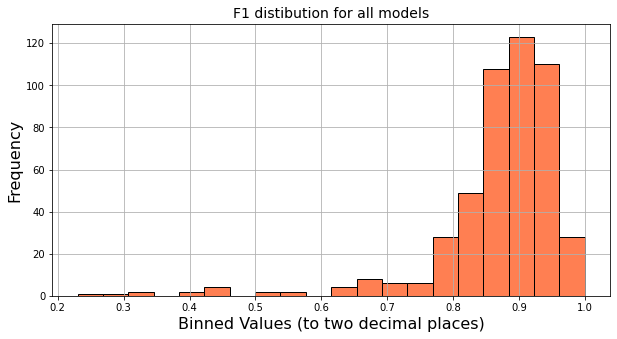

In [0]:
# Define the file path
file_path = "/dbfs/user_data/g07/best_f1_scores.json"

# Load the JSON file
with open(file_path, 'r') as file:
    best_f1_scores = json.load(file)

# Now best_f1_scores contains the data from your JSON file
best_f1_scores
new_positions = [y for x, y in zip(best_f1_scores, positions) if x != 0]
new_f1_scores = [x for x in best_f1_scores if x != 0]
plot_f1_scores(new_f1_scores,new_positions)

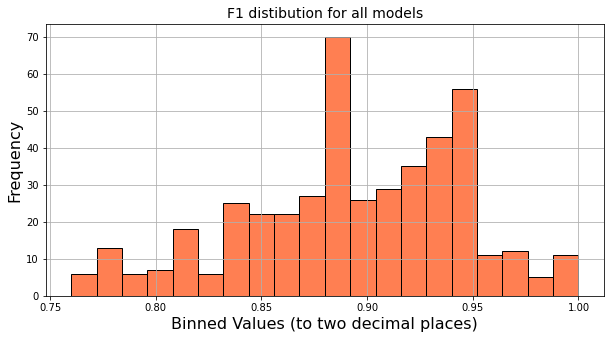

In [0]:
counter = 0
dropped = []
for pos,score in zip (new_positions, new_f1_scores):
    if score < 0.75:
        dropped.append(pos)
        counter+=1
print(counter)
print(dropped)
final_positions = [y for x, y in zip(new_f1_scores, new_positions) if x > 0.75]
final_f1_scores = [x for x in new_f1_scores if x > 0.75]
plot_f1_scores(final_f1_scores,final_positions)
final_positions = json.dumps(final_positions)

# Specify the file path where you want to save the JSON data in DBFS
file_path = "/dbfs/user_data/g07/valid_positions.json"

# Write the JSON string to a file in DBFS
with open(file_path, 'w') as json_file:
    json_file.write(final_positions)

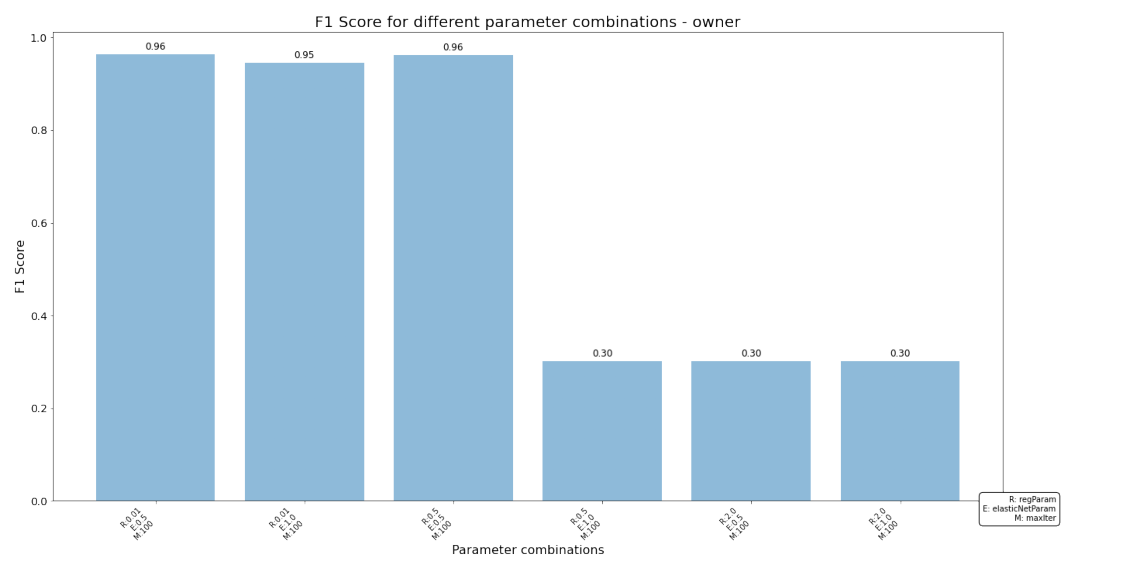

In [0]:
# Open the image file
img = plt.imread("/dbfs/user_data/g07/cv_results_owner.png")

# Display the image
plt.figure(figsize=(20, 20))  # Change the figsize to make the image larger
plt.imshow(img)
plt.axis('off')
plt.show()

In [0]:

# Get user inputs from widgets
user_position = dbutils.widgets.get("Selected Position")
user_id = dbutils.widgets.get("User ID")

# Load the logistic regression model corresponding to the selected position
# Define the model path template
user_position = "teacher"
model_path_template = f"dbfs:/user_data/g07/logistic_model_{user_position}"
model = PipelineModel.load(model_path_template)

# Filter DataFrame to get the user's data row
user_row = df_transformed_with_id.filter(F.col("id") == "corrie-maclean-7a193933").drop("id")
user_row.count()

# Make a prediction using the loaded model
# predicted = model.transform(user_row)
predicted = bestModel.transform(user_row)

# Show the predicted label and probability
predicted.select("prediction", "probability").show()

---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
<command-3328712768040221> in <cell line: 2>()
      1 # Get user inputs from widgets
----> 2 user_position = dbutils.widgets.get("Selected Position")
      3 user_id = dbutils.widgets.get("User ID")
      4 
      5 # Load the logistic regression model corresponding to the selected position

/databricks/python_shell/dbruntime/WidgetHandlerImpl.py in get(self, name)
     40         :return: Current value of the widget or default value
     41         """
---> 42         return self._notebookArguments.getArgument(name, self._entry_point.getCurrentBindings())
     43 
     44     def getArgument(self, name, defaultValue=None):

/databricks/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py in __call__(self, *args)
   1319 
   1320         answer = self.gateway_client.send_command(command)
-> 1321         return_value = get_return

In [0]:
# 1. Aggregate all languages into a single list, then remove duplicates to get unique languages
# IMPORTANT - the order of this array is is the mapping, use for inference time:
unique_languages = df.select(array_distinct(flatten(collect_set("languages"))).alias("languages")).collect()[0]["languages"]

# 2. For each unique language, create a new column indicating the presence or absence of the language
for language in unique_languages:
    df = df.withColumn(
        language,
        F.when(F.array_contains(F.col("languages"), language), 1).otherwise(0)
    )